In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

In [4]:
r= 102317246
a_r = 0.5*(r%7)
b_r = 0.3*(r%5 + 1)

In [6]:
df = pd.read_csv("data.csv")

no2_col = [c for c in df.columns if "NO2" in c.upper()][0]

x = df[no2_col].dropna().values
x = x.reshape(-1,1)


In [7]:
z = x + a_r*np.sin(b_r*x)

# normalize for GAN stability
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

z_tensor = torch.tensor(z_scaled, dtype=torch.float32)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(),lr=0.001)
opt_D = torch.optim.Adam(D.parameters(),lr=0.001)

In [9]:
epochs = 2000
batch_size = 64

for epoch in range(epochs):

    idx = np.random.randint(0,len(z_tensor),batch_size)
    real = z_tensor[idx]

    real_labels = torch.ones(batch_size,1)
    fake_labels = torch.zeros(batch_size,1)

    #train discriminator
    noise = torch.randn(batch_size,1)
    fake = G(noise)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = criterion(D_real,real_labels) + criterion(D_fake,fake_labels)

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # train generator
    noise = torch.randn(batch_size,1)
    fake = G(noise)

    loss_G = criterion(D(fake),real_labels)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch%200==0:
        print(f"Epoch {epoch} | D Loss {loss_D.item():.4f} | G Loss {loss_G.item():.4f}")


Epoch 0 | D Loss 1.4016 | G Loss 0.7706
Epoch 200 | D Loss 1.6106 | G Loss 0.7782
Epoch 400 | D Loss 1.3484 | G Loss 0.6746
Epoch 600 | D Loss 1.3260 | G Loss 0.7015
Epoch 800 | D Loss 1.4160 | G Loss 0.6821
Epoch 1000 | D Loss 1.3813 | G Loss 0.7099
Epoch 1200 | D Loss 1.3637 | G Loss 0.6724
Epoch 1400 | D Loss 1.3873 | G Loss 0.6230
Epoch 1600 | D Loss 1.3689 | G Loss 0.8257
Epoch 1800 | D Loss 1.3951 | G Loss 0.7004


In [10]:
noise = torch.randn(5000,1)
gen_samples = G(noise).detach().numpy()

# inverse scaling
gen_samples = scaler.inverse_transform(gen_samples)
real_samples = scaler.inverse_transform(z_scaled)

In [11]:
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
kde.fit(gen_samples)

z_range = np.linspace(min(gen_samples),max(gen_samples),500)
log_density = kde.score_samples(z_range.reshape(-1,1))
density = np.exp(log_density)

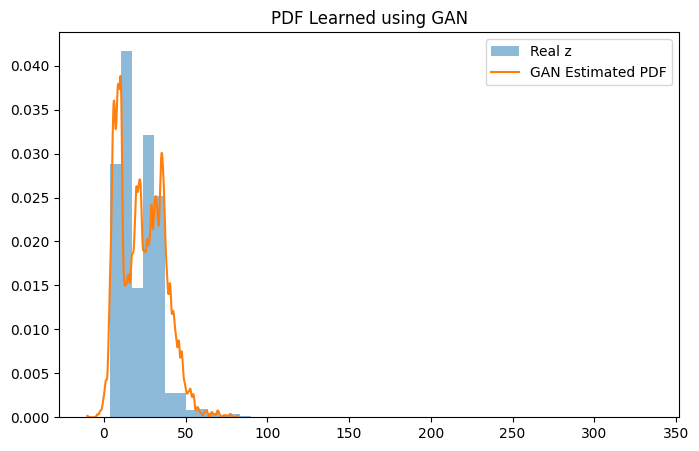

In [12]:
plt.figure(figsize=(8,5))
plt.hist(real_samples,bins=50,density=True,alpha=0.5,label="Real z")
plt.plot(z_range,density,label="GAN Estimated PDF")
plt.legend()
plt.title("PDF Learned using GAN")
plt.show()
